# Creating a basketball mini map using homography transformations

Author Stephan Janssen (sja@devoxx.com)

See also related [article on LinkedIn](https://www.linkedin.com/pulse/journey-towards-creating-basketball-mini-map-stephan-janssen/).

We still need to identify the players per team which can be achieved using colour detection, that's not too difficult.

Improvements or suggestions are always welcome!

# Install detectron2

In [1]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.2)
Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.14)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-9zv055xw
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-9zv055xw
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-k6nuduvz
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-k6nuduvz
     |████████████████████████████████| 266kB 37.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=34200 sha256=96a3e892fe7f90d3b3eb29fdac8e7b12115a8ffc9d3f308275f1bfba0b72e6b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-pugys4hk/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel 

'1.3.1'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 2015 (delta 19), reused 32 (delta 13), pack-reused 1957
Receiving objects: 100% (2015/2015), 1.78 MiB | 1.35 MiB/s, done.
Resolving deltas: 100% (1284/1284), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 2.1MB 25.7MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Running setup.py develop for detectron2


In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect

# Some basic setup

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Run a pre-trained detectron2 model

We first download a random image from the COCO dataset:

--2019-12-27 16:21:45--  https://basketball-ml.s3-eu-west-1.amazonaws.com/3DBasketballMiddleView.jpg
Resolving basketball-ml.s3-eu-west-1.amazonaws.com (basketball-ml.s3-eu-west-1.amazonaws.com)... 52.218.109.176
Connecting to basketball-ml.s3-eu-west-1.amazonaws.com (basketball-ml.s3-eu-west-1.amazonaws.com)|52.218.109.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77867 (76K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>]  76.04K   131KB/s    in 0.6s    

2019-12-27 16:21:47 (131 KB/s) - ‘input.jpg’ saved [77867/77867]



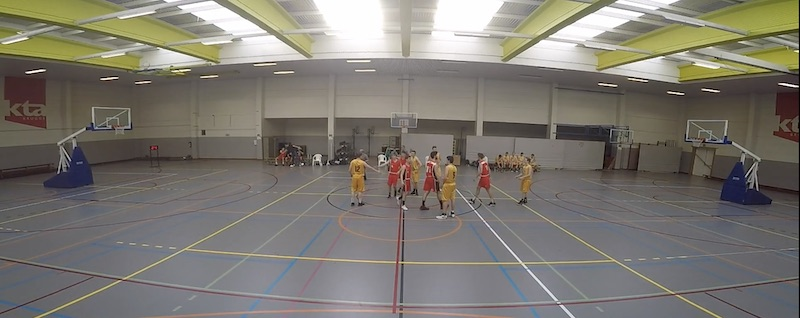

In [2]:
!wget https://basketball-ml.s3-eu-west-1.amazonaws.com/3DBasketballMiddleView.jpg -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [3]:
cfg = get_cfg()

cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"

predictor = DefaultPredictor(cfg)

outputs = predictor(im)

WARNING [12/27 16:22:01 d2.config.compat]: Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


model_final_f10217.pkl: 178MB [00:20, 8.74MB/s]                           


In [7]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
instances = outputs["instances"]
print(instances)
pred_boxes = instances.get("pred_boxes")
pred_classes = instances.get("pred_classes")
print(pred_boxes)
print(pred_classes)

Instances(num_instances=9, image_height=318, image_width=800, fields=[pred_boxes, scores, pred_classes, pred_keypoints])
Boxes(tensor([[348.6163, 150.5828, 368.8826, 207.7443],
        [471.9114, 154.3922, 496.3904, 206.8275],
        [515.1798, 156.2779, 534.5811, 204.8009],
        [440.1763, 154.7427, 457.8997, 217.5987],
        [386.3991, 153.1137, 401.6183, 199.6092],
        [418.4916, 151.1510, 443.9608, 210.5896],
        [276.3792, 145.8591, 287.1940, 165.7038],
        [395.7417, 153.6459, 412.4528, 208.7750],
        [407.2267, 150.3469, 422.6573, 197.4714]], device='cuda:0'))
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


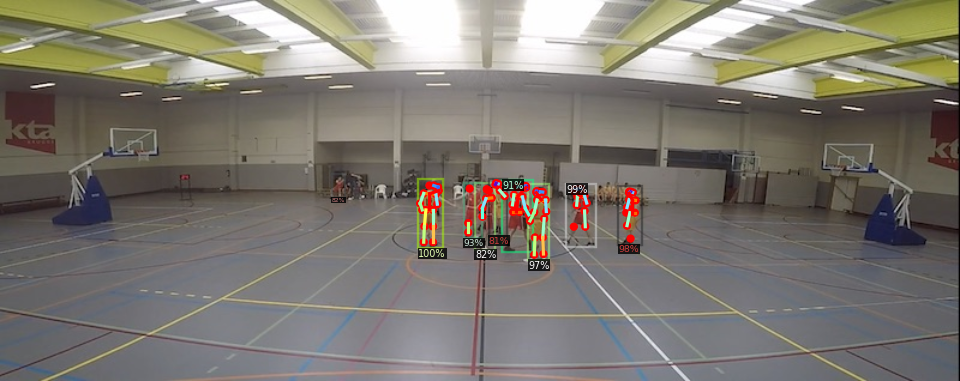

In [110]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

# Other types of builtin models

WARNING [12/27 16:23:09 d2.config.compat]: Config './detectron2_repo/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


model_final_a6e10b.pkl: 237MB [00:26, 9.01MB/s]                           


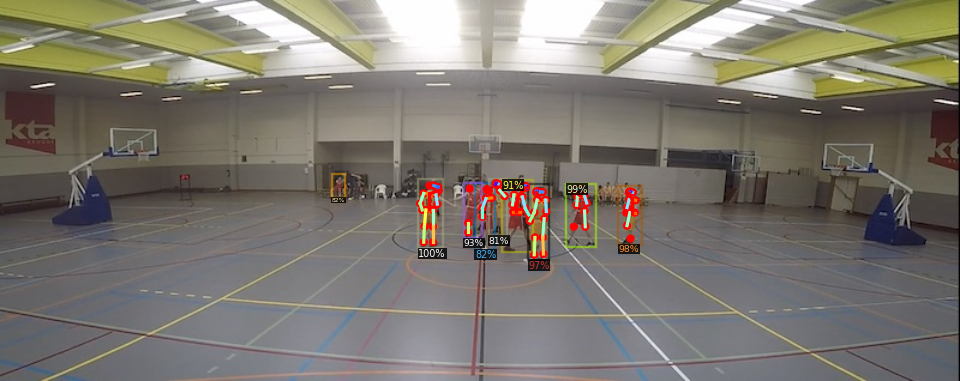

In [6]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = "detectron2://COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

WARNING [12/21 09:26:08 d2.config.compat]: Config './detectron2_repo/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


model_final_cafdb1.pkl: 261MB [00:04, 58.0MB/s]                           


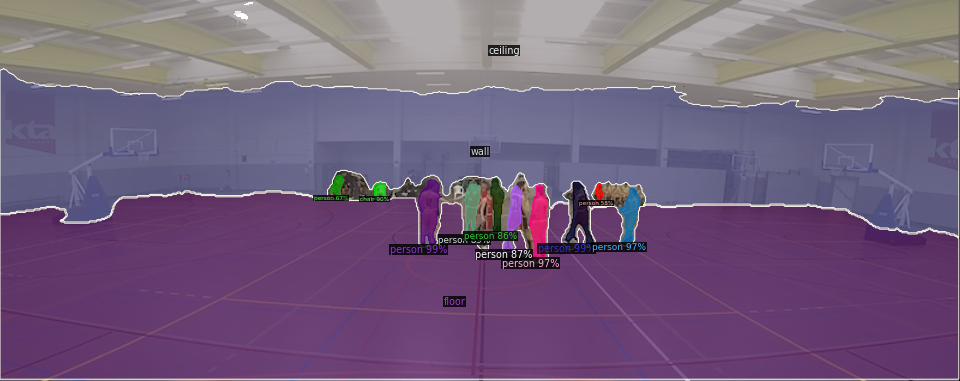

In [0]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
cfg.MODEL.WEIGHTS = "detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl"
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(v.get_image()[:, :, ::-1])

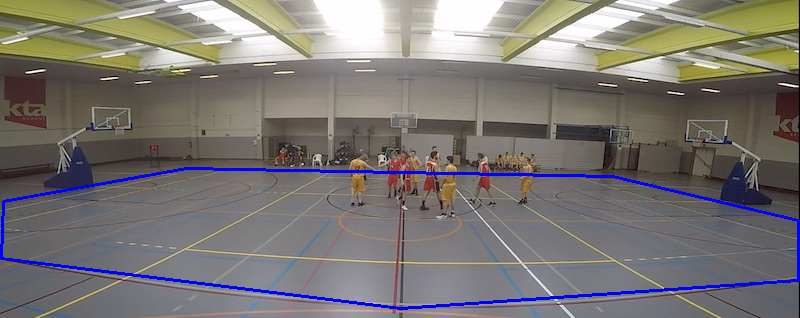

In [4]:
# Four corners of the 3D court + mid-court circle point in source image
# Start top-left corner and go anti-clock wise + mid-court circle point
src_pts = np.array([
    [1, 258],       # left bottom - bottom corner
    [400, 308],     # middle bottom corner
    [798, 280],     # right bottom - bottom corner
    [798, 220],     # right bottom - top corner
    [612, 176],     # top right rorner
    [186, 168],     # top left corner
    [3, 201]        # left bottom - top corner
    ])   

im_poly = im.copy()

# cv2.fillPoly(img_src, [src_pts], 255)
cv2.polylines(im_poly, [src_pts], isClosed=True, color=[255,0,0], thickness=2)

cv2_imshow(im_poly)

Player positions (x,y) :
[ 358,  207]
[ 483,  206]
[ 524,  204]
[ 448,  217]
[ 393,  199]
[ 430,  210]
[ 281,  165]
[ 403,  208]
[ 414,  197]


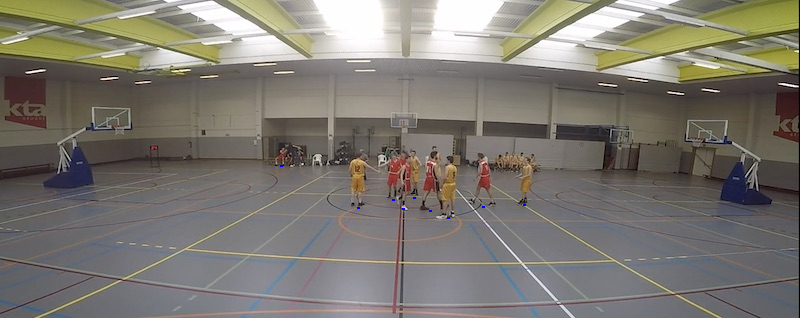

In [17]:
# Use the boxes info from the tensor prediction result
#
# x1,y1 ------
# |          |
# |          |
# |          |
# --------x2,y2
#
from shapely.geometry import Point, Polygon

color = [255, 0, 0]   
thickness = 1
radius = 1

print("Player positions (x,y) :")

i  = 0
for box in pred_boxes:
  
  # Include only class Person
  if pred_classes[i] == 0:  
      
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    xc = x1 + int((x2 - x1)/2)
    player_pos1 = (xc - 1, y2)
    player_pos2 = (xc + 1, y2 + 1)

    court = Polygon(src_pts)

    # Draw only players that are within the basketball court
    if Point(player_pos).within(court):
      print("[% 3d, % 3d]" %(xc, y2))
      # cv2.circle(im, player_pos, radius, color, thickness, lineType=8, shift=0)
      # cv2.line(img, pt1, pt2, color[, thickness[, lineType[, shift]]]) → None¶
      # cv2.line(im, player_pos1, player_pos2, color, thickness)
      cv2.rectangle(im, player_pos1, player_pos2, color, thickness)
    i = i + 1

cv2_imshow(im)

--2019-12-27 16:27:11--  https://basketball-ml.s3-eu-west-1.amazonaws.com/2DBasketballCourtV2.jpg
Resolving basketball-ml.s3-eu-west-1.amazonaws.com (basketball-ml.s3-eu-west-1.amazonaws.com)... 52.218.105.99
Connecting to basketball-ml.s3-eu-west-1.amazonaws.com (basketball-ml.s3-eu-west-1.amazonaws.com)|52.218.105.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36257 (35K) [image/jpeg]
Saving to: ‘court.jpg’

court.jpg           100%[===================>]  35.41K  41.0KB/s    in 0.9s    

2019-12-27 16:27:13 (41.0 KB/s) - ‘court.jpg’ saved [36257/36257]



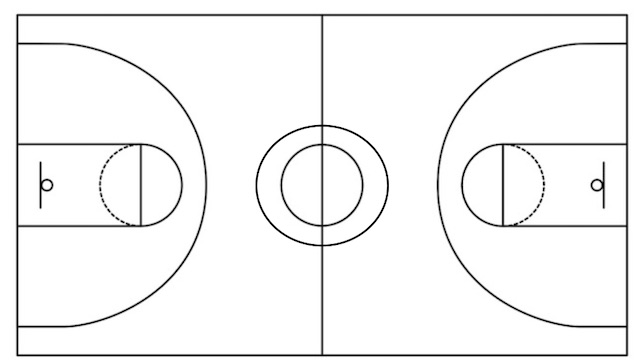

In [18]:
!wget https://basketball-ml.s3-eu-west-1.amazonaws.com/2DBasketballCourtV2.jpg -O court.jpg
img_dst = cv2.imread('./court.jpg')
cv2_imshow(img_dst)

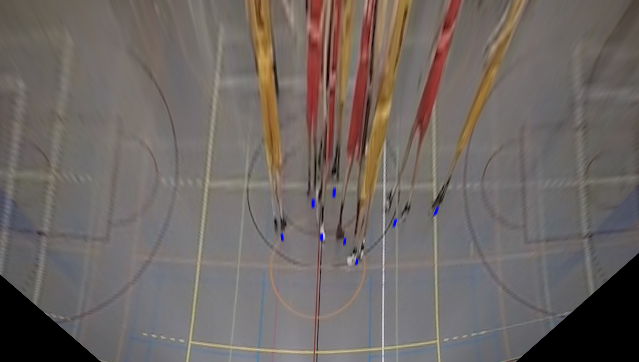

In [19]:
# Four corners of the court + mid-court circle point in destination image 
# Start top-left corner and go anti-clock wise + mid-court circle point
dst_pts = np.array([
    [43, 355],       # left bottom - bottom corner
    [317, 351],      # middle bottom corner
    [563, 351],      # right bottom - bottom corner
    [629, 293],      # right bottom - top corner
    [628, 3],        # top right rorner
    [8, 4],          # top left corner
    [2, 299]         # left bottom - top corner
    ])   

# Calculate Homography
h, status = cv2.findHomography(src_pts, dst_pts)
img_out = cv2.warpPerspective(im, h, (img_dst.shape[1], img_dst.shape[0]))
cv2_imshow(img_out)

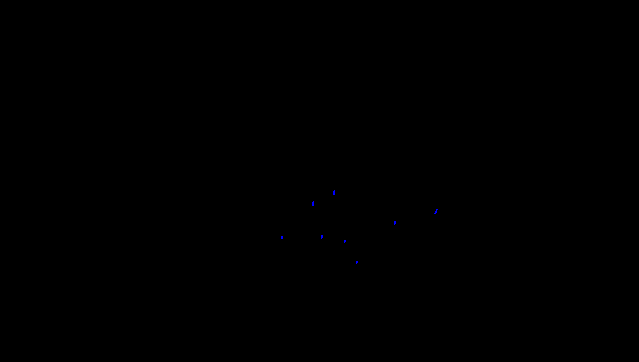

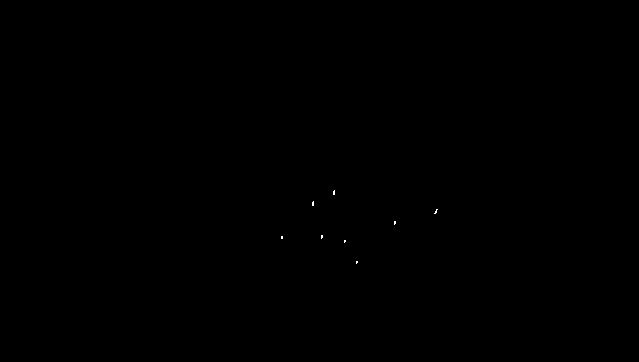

In [20]:
lower_range = np.array([255,0,0])                         # Set the Lower range value of blue in BGR
upper_range = np.array([255,155,155])                     # Set the Upper range value of blue in BGR
mask = cv2.inRange(img_out, lower_range, upper_range)     # Create a mask with range
result = cv2.bitwise_and(img_out, img_out, mask = mask)   # Performing bitwise and operation with mask in img variable
# cv2_imshow(result)                              

mask = cv2.inRange(result, lower_range, upper_range)  
cv2_imshow(mask)                              

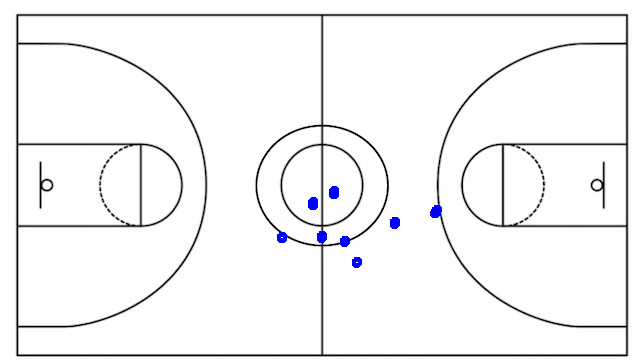

In [25]:
from scipy.spatial import distance as dist

#get all non zero values
coord = cv2.findNonZero(mask)

# Radius of circle 
radius = 3
   
# Blue color in BGR 
color = (255, 0, 0) 

# Line thickness of 2 px 
thickness = 2

court_img = cv2.imread('./court.jpg')
for pos in coord:
  center_coordinates = (pos[0][0], pos[0][1])
  cv2.circle(court_img, center_coordinates, radius, color, thickness) 

cv2_imshow(court_img)